In [378]:
# Jump-Start for the Bank Marketing Study
# as described in Marketing Data Science: Modeling Techniques
# for Predictive Analytics with R and Python (Miller 2015)

# jump-start code revised by Thomas W. Milller (2018/10/07)

# Scikit Learn documentation for this assignment:
# http://scikit-learn.org/stable/auto_examples/classification/
#   plot_classifier_comparison.html
# http://scikit-learn.org/stable/modules/generated/
#   sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB.score
# http://scikit-learn.org/stable/modules/generated/
#   sklearn.linear_model.LogisticRegression.html
# http://scikit-learn.org/stable/modules/model_evaluation.html 
# http://scikit-learn.org/stable/modules/generated/
#  sklearn.model_selection.KFold.html

# prepare for Python version 3x features and functions
# comment out for Python 3.x execution
# from __future__ import division, print_function
# from future_builtins import ascii, filter, hex, map, oct, zip

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# import base packages into the namespace for this program
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
import matplotlib
import matplotlib.pyplot as plt # static plotting
import seaborn as sns # pretty plotting, including heat map
%matplotlib inline
matplotlib.style.use('ggplot')

In [379]:
# initial work with the smaller data set
bank = pd.read_csv('bank.csv', sep = ';')  # start with smaller data set
# examine the shape of original input data
bank.shape

(4521, 17)

In [380]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [381]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [382]:
pd.option_context('display.max_rows', None, 'display.max_columns', None)
# Count value distribution for three predictors: default, housing and loan
count_default = bank['default'].value_counts().to_dict()
count_housing = bank['housing'].value_counts().to_dict()
count_loan    = bank['loan'].value_counts().to_dict()
count_response = bank['response'].value_counts().to_dict()

print('default:', count_default)
print('housing:', count_housing)
print('loan:', count_loan)
print('response:', count_response)

default: {'no': 4445, 'yes': 76}
housing: {'yes': 2559, 'no': 1962}
loan: {'no': 3830, 'yes': 691}
response: {'no': 4000, 'yes': 521}


In [383]:
# drop observations with missing data, if any
bank1 = bank.dropna()
# examine the shape of input data after dropping missing data
bank1.shape
# Therefore, no na in the original dataset.

(4521, 17)

In [384]:
# look at the list of column names, note that y is the response
bank.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
response     object
dtype: object

In [385]:
# mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

In [386]:
# define binary variable for having credit in default
default = bank['default'].map(convert_to_binary)
housing = bank['housing'].map(convert_to_binary)
loan    = bank['loan'].map(convert_to_binary)
response= bank['response'].map(convert_to_binary)

bank['default'] = bank['default'].map(convert_to_binary)
bank['housing'] = bank['housing'].map(convert_to_binary)
bank['loan'] = bank['loan'].map(convert_to_binary)
bank['response1'] = bank['response'].map(convert_to_binary)


In [387]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response,response1
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,-1,0,unknown,no,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339,4,failure,no,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330,1,failure,no,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,-1,0,unknown,no,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,-1,0,unknown,no,0


In [388]:
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)

<Figure size 432x288 with 0 Axes>

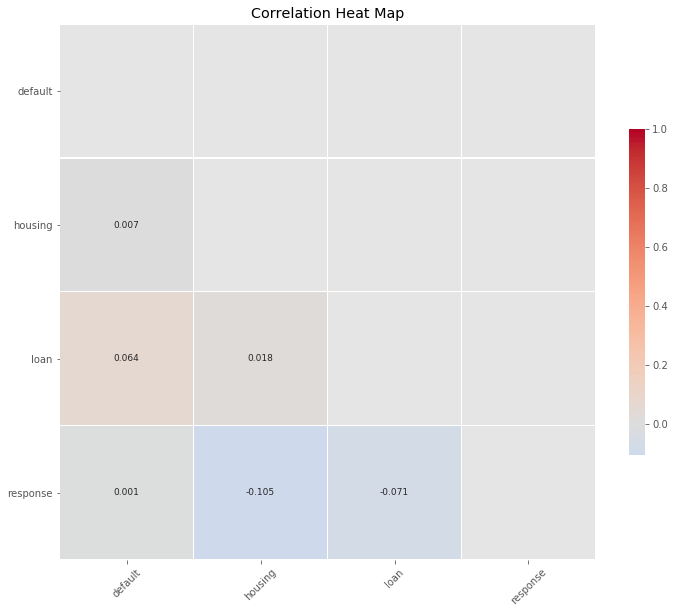

In [389]:
# examine intercorrelations among three predictors and one target variables 
# with correlation matrix/heat map
corr_chart(df_corr = bank2)

In [390]:
#split dataset in predictors and target variable
# default, loan, housing
X = bank[['default','loan','housing']]     # predictors
y = bank[['response1']]       # Target
# split X and y into training and testing sets
# using the complete data set, no splitting
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=0)

In [391]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
# fit the model with data
logreg.fit(X_train,y_train)
# calculate the 
y_pred=logreg.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [392]:
# import the metrics class
from sklearn import metrics
lr_matrix = metrics.confusion_matrix(y_test, y_pred)
lr_matrix

array([[1190,    0],
       [ 167,    0]], dtype=int64)

In [393]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8769344141488578
Precision: 0.0
Recall: 0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


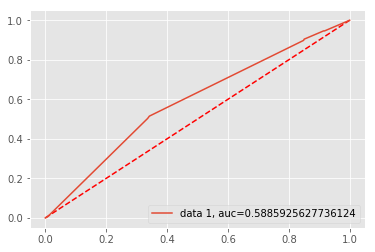

In [394]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot([0, 1], [0, 1],'r--')
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
# For default, ROC is 0.49727
# For loan, ROC is 0.52473
# For housing, ROC is 0.57461
# For default, loan housing three variables together ROC: 0.588592

In [395]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, X_test, y_test, cv=10)
print(scores)
print('average score: {}'.format(scores.mean()))

# For default, score: is 0.87694
# For loan, score is 0.87694
# For housing, ROC is 0.88476
# For default, loan housing three variables together ROC: 0.88476

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_

[0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.881 0.881 0.881]
average score: 0.8769444444444444


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_

In [396]:
# Naive Bayes regression test 
from sklearn.naive_bayes import GaussianNB

#split dataset in predictors and target variable
# default, loan, housing
X = bank[['housing','loan','default']]     # predictors
y = bank[['response1']]                    # Target
# split X and y into training and testing sets
# using the complete data set, no splitting
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=0)

clf = GaussianNB()
clf.fit(X_train,y_train)
NB_pred = clf.predict(X_test)

# Accuracy of our Gaussian Naive Bayes model
metrics.accuracy_score(y_test, NB_pred)

# Default ROC: 0.87693
# housing ROC: 0.87693
# loan ROC   : 0.87693
# For default, loan housing three variables together ROC: 0.87693

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8769344141488578

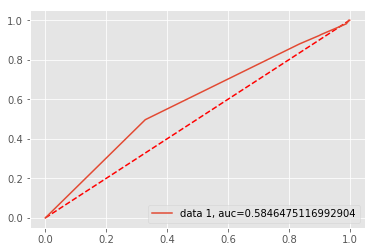

In [397]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot([0, 1], [0, 1],'r--')
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Default ROC: 0.49727
# housing ROC: 0.57461
# loan ROC   : 0.52473
# For default, loan housing three variables together ROC: 0.58464


In [398]:
scores = cross_val_score(clf, X_test, y_test, cv=10)
print(scores)
print('average score: {}'.format(scores.mean()))

# For default, score: is 0.86517
# For loan, score is 0.87694
# For housing, ROC is 0.87694
# For default, loan housing three variables together ROC: 0.86444

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[0.838 0.853 0.86  0.86  0.86  0.86  0.875 0.874 0.881 0.881]
average score: 0.8644389978213509


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
